In [2]:
!git clone https://github.com/intsystems/SToG.git

Cloning into 'SToG'...
remote: Enumerating objects: 330, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 330 (delta 23), reused 8 (delta 8), pack-reused 297 (from 1)
Receiving objects: 100% (330/330), 9.91 MiB | 16.26 MiB/s, done.
Resolving deltas: 100% (114/114), done.


In [3]:
!cd SToG/src/mylib

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import math
import numpy as np
from abc import ABC, abstractmethod
from sklearn.datasets import load_breast_cancer, load_wine, make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
import warnings
warnings.filterwarnings('ignore')

from SToG.src.mylib.stochastic_gating_complete import STGLayer, STELayer, GumbelLayer, CorrelatedSTGLayer, L1Layer

class ModelFeatureSelection(nn.Module):
    def __init__(self, model: nn.Sequential, selection_layers):
        super().__init__()

        for el in selection_layers:
            if el[0] < 0 or el[0] > len(list(model)) - 1:
                raise ValueError("Selection layers must be in the range [1, num_operations]")

        layers = list(model)

        for idx, layer in sorted(selection_layers, key=lambda x: x[0], reverse=True):
            layers.insert(idx, layer)

        self.sel_layer_indices = [el[0] + i for i, el in enumerate(selection_layers)]

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

In [5]:
class DatasetLoader:
    """Load and prepare datasets for benchmarking."""

    @staticmethod
    def load_breast_cancer():
        """Load breast cancer dataset."""
        data = load_breast_cancer()
        return {
            'name': 'Breast Cancer',
            'X': data.data,
            'y': data.target,
            'n_important': 10,
            'description': 'Binary classification, 30 features'
        }

    @staticmethod
    def load_wine():
        """Load wine dataset."""
        data = load_wine()
        return {
            'name': 'Wine',
            'X': data.data,
            'y': data.target,
            'n_important': 7,
            'description': '3-class classification, 13 features'
        }

    @staticmethod
    def create_synthetic_high_dim():
        """Create synthetic high-dimensional dataset (MADELON-like)."""
        X, y = make_classification(
            n_samples=600,
            n_features=100,
            n_informative=5,
            n_redundant=10,
            n_repeated=0,
            n_classes=2,
            n_clusters_per_class=2,
            flip_y=0.03,
            class_sep=1.0,
            random_state=42
        )
        return {
            'name': 'Synthetic-HighDim',
            'X': X,
            'y': y,
            'n_important': 5,
            'description': 'Binary classification, 100 features, 5 informative'
        }

    @staticmethod
    def create_synthetic_correlated():
        """Create synthetic dataset with correlated features."""
        np.random.seed(42)
        n_samples = 500
        n_informative = 5
        n_total = 50

        X_inform = np.random.randn(n_samples, n_informative)

        X_redundant = []
        for i in range(n_informative):
            for _ in range(2):
                noise = np.random.randn(n_samples) * 0.1
                X_redundant.append(X_inform[:, i] + noise)
        X_redundant = np.column_stack(X_redundant)

        n_noise = n_total - n_informative - X_redundant.shape[1]
        X_noise = np.random.randn(n_samples, n_noise)

        X = np.column_stack([X_inform, X_redundant, X_noise])

        y = (X_inform[:, 0] + X_inform[:, 1] * X_inform[:, 2] > 0).astype(int)

        return {
            'name': 'Synthetic-Correlated',
            'X': X,
            'y': y,
            'n_important': n_informative,
            'description': f'Binary classification, {n_total} features, {n_informative} informative with correlated copies'
        }

In [25]:
def train_epoch(model, criterion, X_train, y_train, X_val, y_val, lambda_reg, n_features):
    """Train for one epoch."""
    model.train()

    optimizer.zero_grad()

    predictions = model(X_train)

    classification_loss = criterion(predictions, y_train)
    regularization_loss = sum(model.layers[i].regularization_loss() for i in model.sel_layer_indices) / n_features
    total_loss = classification_loss + lambda_reg * regularization_loss

    total_loss.backward()

    torch.nn.utils.clip_grad_norm_(
        list(model.parameters()),
        max_norm=1.0
    )

    optimizer.step()

    model.eval()

    with torch.no_grad():
        val_predictions = model(X_val)
        val_loss = criterion(val_predictions, y_val)
        val_acc = (val_predictions.argmax(1) == y_val).float().mean().item() * 100
        sel_count = sum(model.layers[i].get_selected_features().sum() for i in model.sel_layer_indices)

    return {
        'classification_loss': classification_loss.item(),
        'reg_loss': regularization_loss.item(),
        'val_loss': val_loss.item(),
        'val_acc': val_acc,
        'sel_count': sel_count
    }

In [26]:
def fit(model, criterion, X_train, y_train, X_val, y_val, lambda_reg, n_features, epochs=300,
            patience=50, verbose=False):
        """
        Train the model with early stopping.
        """
        best_val_acc = 0
        wait = 0
        history = {'classification_loss': [], 'val_loss': [], 'val_acc': [], 'sel_count': [], 'reg_loss': []}
        best_state = {}

        for epoch in range(epochs):
            metrics = train_epoch(model, criterion, X_train, y_train, X_val, y_val, lambda_reg, n_features)

            for key, value in metrics.items():
                history[key].append(value)

            if metrics['val_acc'] > best_val_acc:
                best_val_acc = metrics['val_acc']
                wait = 0
                best_state = {
                    'model': model.state_dict(),
                    'epoch': epoch,
                    'val_acc': best_val_acc,
                    'sel_count': metrics['sel_count']
                }
            else:
                wait += 1

            if wait >= patience and epoch >= 100:
                if verbose:
                    print(f"Early stopping at epoch {epoch+1}")
                break

            if verbose and (epoch + 1) % 50 == 0:
                print(f"Epoch {epoch+1}: "
                      f"val_acc={metrics['val_acc']:.2f}%, "
                      f"sel={metrics['sel_count']}, "
                      f"λ={lambda_reg:.4f}")

        if best_state:
            model.load_state_dict(best_state['model'])

        return history

In [65]:
def plot_comparison_12figures(metrics_dict, file_name, lambda_):

    colors = {'classification_loss': '#1f77b4', 'reg_loss': '#ff7f0e', 'val_acc': '#2ca02c', 'sel_count': '#d62728', 'val_loss': '#d62728'}
    markers = {'classification_loss': 'o', 'reg_loss': 's', 'val_acc': '^', 'sel_count': 'D'}

    fig = plt.figure(figsize=(24, 5))

    # =====================================================================
    # 1. CE loss по эпохам
    # =====================================================================
    ax1 = plt.subplot(1, 4, 1)
    epochs = list(range(1, len(metrics_dict['classification_loss']) + 1))
    ax1.plot(epochs, metrics_dict['classification_loss'],
            color=colors['classification_loss'], marker=markers['classification_loss'],
            label='classification_loss'.capitalize(), linewidth=2.5, markersize=6, alpha=0.8)
    ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
    ax1.set_ylabel('CE loss', fontsize=12, fontweight='bold')
    ax1.set_title('CE loss по эпохам', fontsize=13, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    # ax1.set_ylim([80, 95])

    # =====================================================================
    # 2. Regularization Loss по эпохам
    # =====================================================================
    ax2 = plt.subplot(1, 4, 2)
    epochs = list(range(1, len(metrics_dict['reg_loss']) + 1))
    ax2.plot(epochs, metrics_dict['reg_loss'],
            color=colors['reg_loss'], marker=markers['reg_loss'],
            label='reg_loss'.capitalize(), linewidth=2.5, markersize=6, alpha=0.8)
    ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Regularization Loss', fontsize=12, fontweight='bold')
    ax2.set_title('Regularization Loss по эпохам', fontsize=13, fontweight='bold')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)

    # =====================================================================
    # 3. Validation accuracy
    # =====================================================================
    ax3 = plt.subplot(1, 4, 3)
    epochs = list(range(1, len(metrics_dict['val_acc']) + 1))
    ax3.plot(epochs, metrics_dict['val_acc'],
            color=colors['val_acc'], marker=markers['val_acc'],
            label='val_acc'.capitalize(), linewidth=2.5, markersize=6, alpha=0.8)
    ax3.set_xlabel('Epoch', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
    ax3.set_title('Validation accuracy', fontsize=13, fontweight='bold')
    ax3.legend(fontsize=11)
    ax3.grid(True, alpha=0.3)

    # =====================================================================
    # 4. Selected features
    # =====================================================================
    ax4 = plt.subplot(1, 4, 4)
    epochs = list(range(1, len(metrics_dict['sel_count']) + 1))
    ax4.plot(epochs, metrics_dict['sel_count'],
            color=colors['sel_count'], marker=markers['sel_count'],
            label='sel_count'.capitalize(), linewidth=2.5, markersize=6, alpha=0.8)
    ax4.set_xlabel('Epoch', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Selected features', fontsize=12, fontweight='bold')
    ax4.set_title('Selected features', fontsize=13, fontweight='bold')
    ax4.legend(fontsize=11)
    ax4.grid(True, alpha=0.3)

    fig.suptitle(f"λ = {lambda_}", fontsize=16)

    plt.show()

    save_path = file_name
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    #print(f"✓ Графики сохранены: {save_path}")
    plt.close()

# Feature selection using SToG

We are going to demonstrate all realised methods on several datasets, analyzing different aspects of performance.

### Breast cancer dataset

In [50]:
dataset = DatasetLoader().load_breast_cancer()
random_state = 42

lambda_reg_array = [0.0001, 0.001, 0.01, 0.05, 0.1] # array of lambda values
device = 'cpu'
criterion = nn.CrossEntropyLoss()

X, y = dataset['X'], dataset['y']
n_features = X.shape[1]
n_classes = len(np.unique(y))

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_state, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=random_state, stratify=y_temp
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train_t = torch.FloatTensor(X_train).to(device)
y_train_t = torch.LongTensor(y_train).to(device)
X_val_t = torch.FloatTensor(X_val).to(device)
y_val_t = torch.LongTensor(y_val).to(device)
X_test_t = torch.FloatTensor(X_test).to(device)
y_test_t = torch.LongTensor(y_test).to(device)

#### Feature selection using STGLayer



In [29]:
model_stg = ModelFeatureSelection(nn.Sequential(
    nn.Linear(30, 10),
    nn.ReLU(),
    nn.Linear(10, 5),
    nn.ReLU(),
    nn.Linear(5, 2)
), [(0, STGLayer(30))])


optimizer = optim.Adam([
    {"params": model_stg.layers[i].parameters(), "lr": 1e-2} if i in model_stg.sel_layer_indices else {"params": model_stg.layers[i].parameters(), "lr": 1e-3, "weight_decay": 1e-4} for i in range(len(list(model_stg.layers)))
])

In [34]:
breast_cancer_stg_res = {}
for lambda_reg in lambda_reg_array:
    model_stg = ModelFeatureSelection(nn.Sequential(
        nn.Linear(30, 10),
        nn.ReLU(),
        nn.Linear(10, 5),
        nn.ReLU(),
        nn.Linear(5, 2)
    ), [(0, STGLayer(30))])


    optimizer = optim.Adam([
        {"params": model_stg.layers[i].parameters(), "lr": 1e-2} if i in model_stg.sel_layer_indices else {"params": model_stg.layers[i].parameters(), "lr": 1e-3, "weight_decay": 1e-4} for i in range(len(list(model_stg.layers)))
    ])
    breast_cancer_stg_res[lambda_reg] = fit(model_stg, criterion, X_train_t, y_train_t, X_val_t, y_val_t, lambda_reg, n_features)

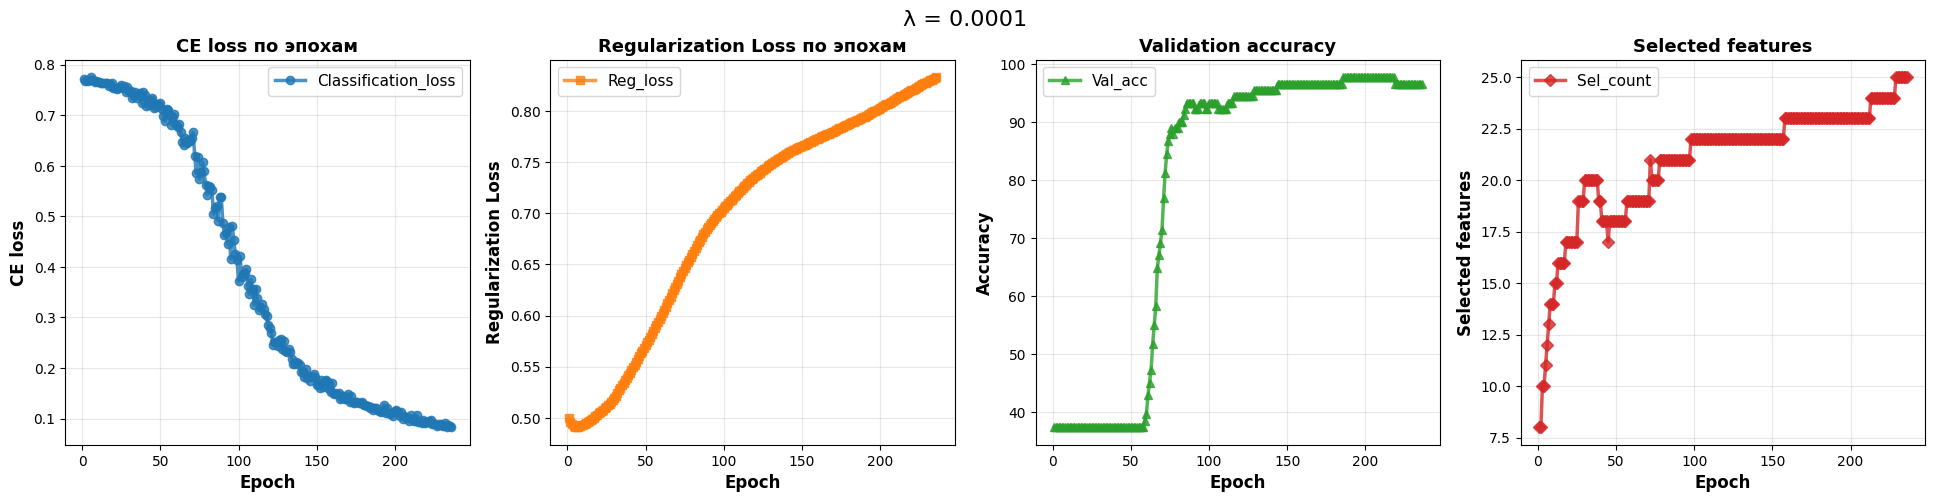

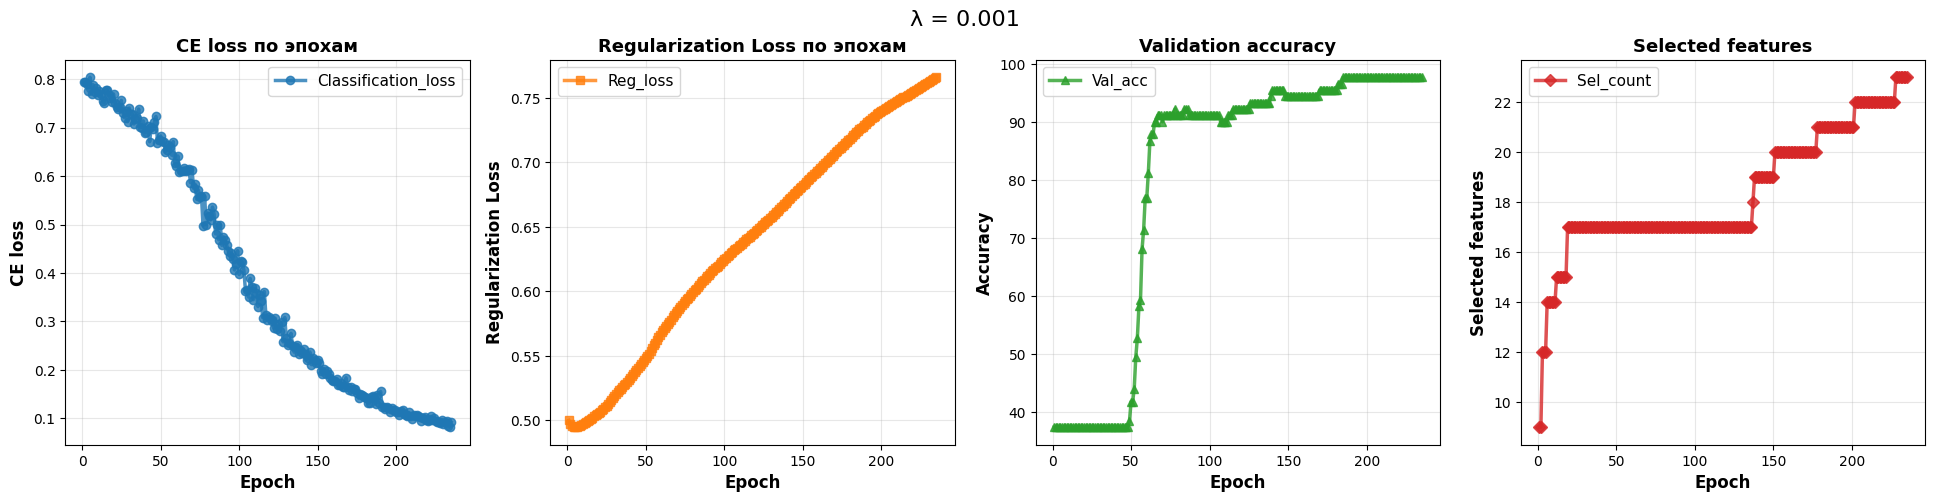

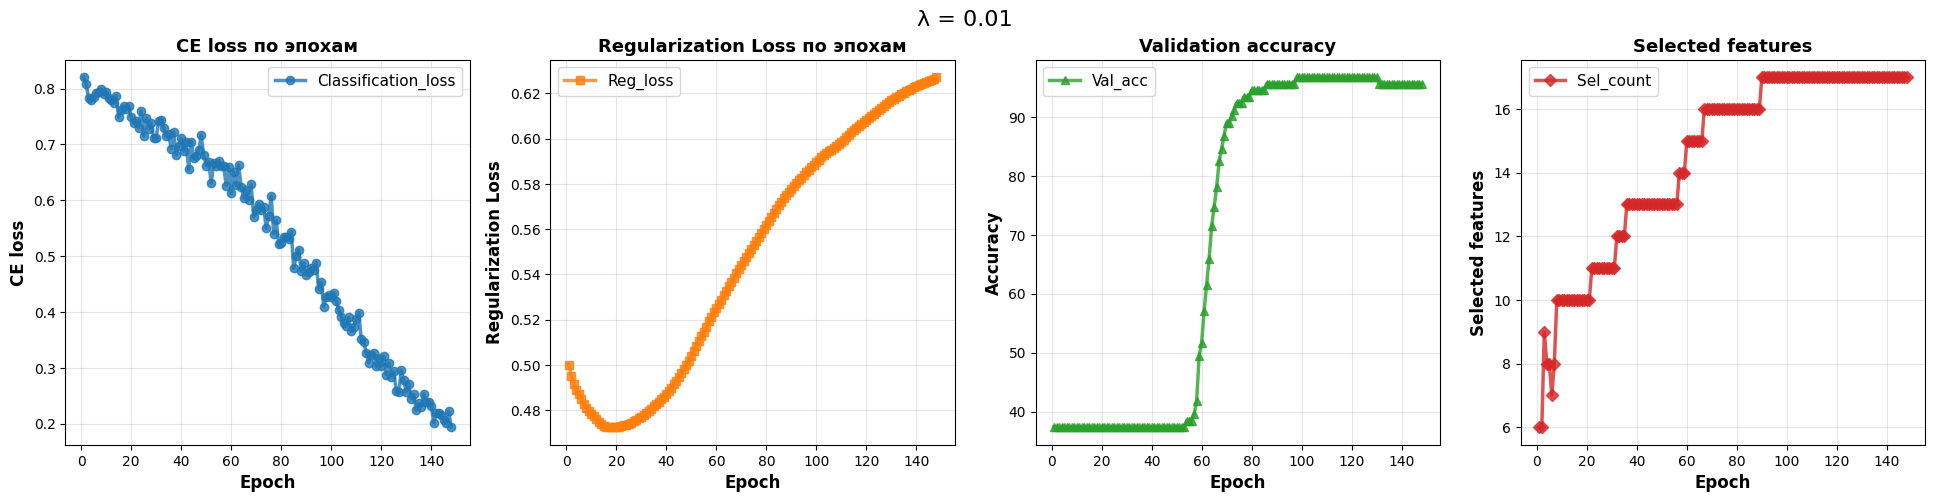

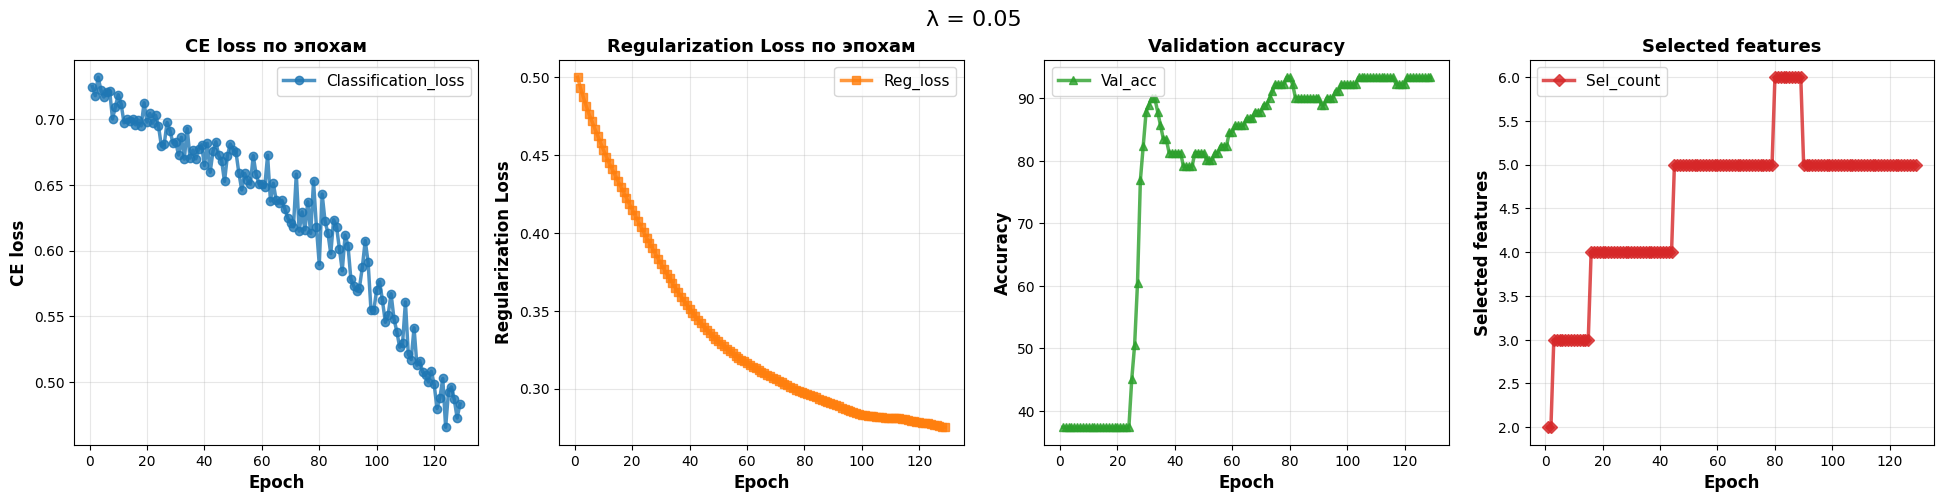

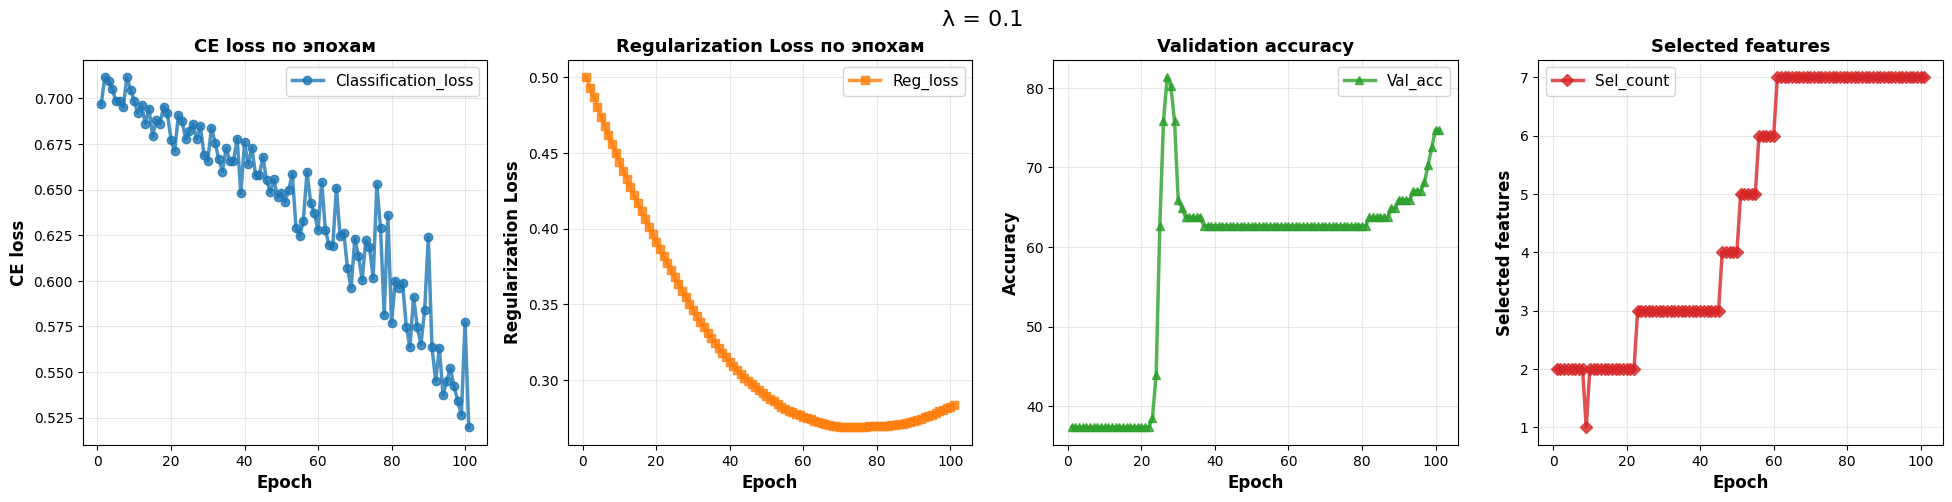

In [66]:
for key in breast_cancer_stg_res.keys():
  plot_comparison_12figures(breast_cancer_stg_res[key], file_name=f'Stg_breast_cancer_lambda_{key}.png', lambda_=key)

#### Feature selection using STELayer

In [55]:
breast_cancer_ste_res = {}
for lambda_reg in lambda_reg_array:
    model_ste = ModelFeatureSelection(nn.Sequential(
        nn.Linear(30, 10),
        nn.ReLU(),
        nn.Linear(10, 5),
        nn.ReLU(),
        nn.Linear(5, 2)
    ), [(0, STELayer(30))])


    optimizer = optim.Adam([
        {"params": model_ste.layers[i].parameters(), "lr": 1e-2} if i in model_ste.sel_layer_indices else {"params": model_ste.layers[i].parameters(), "lr": 1e-3, "weight_decay": 1e-4} for i in range(len(list(model_ste.layers)))
    ])
    breast_cancer_ste_res[lambda_reg] = fit(model_ste, criterion, X_train_t, y_train_t, X_val_t, y_val_t, lambda_reg, n_features)

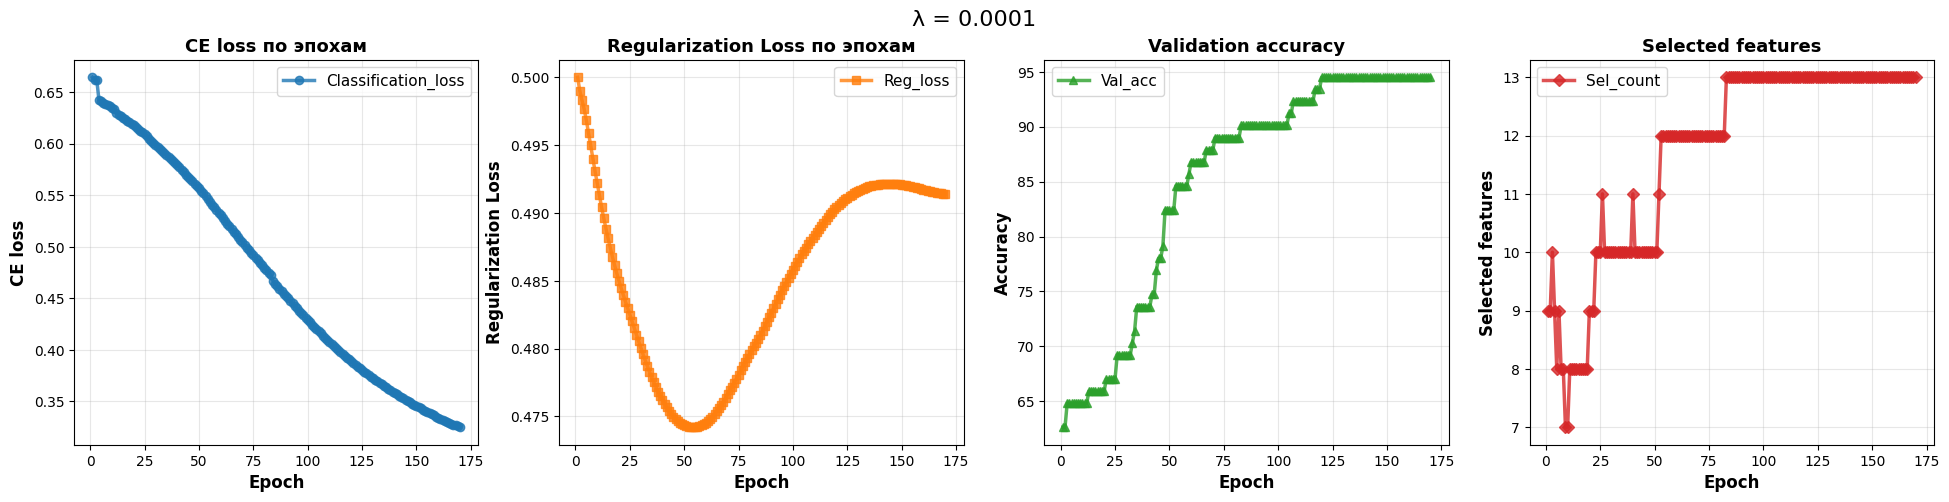

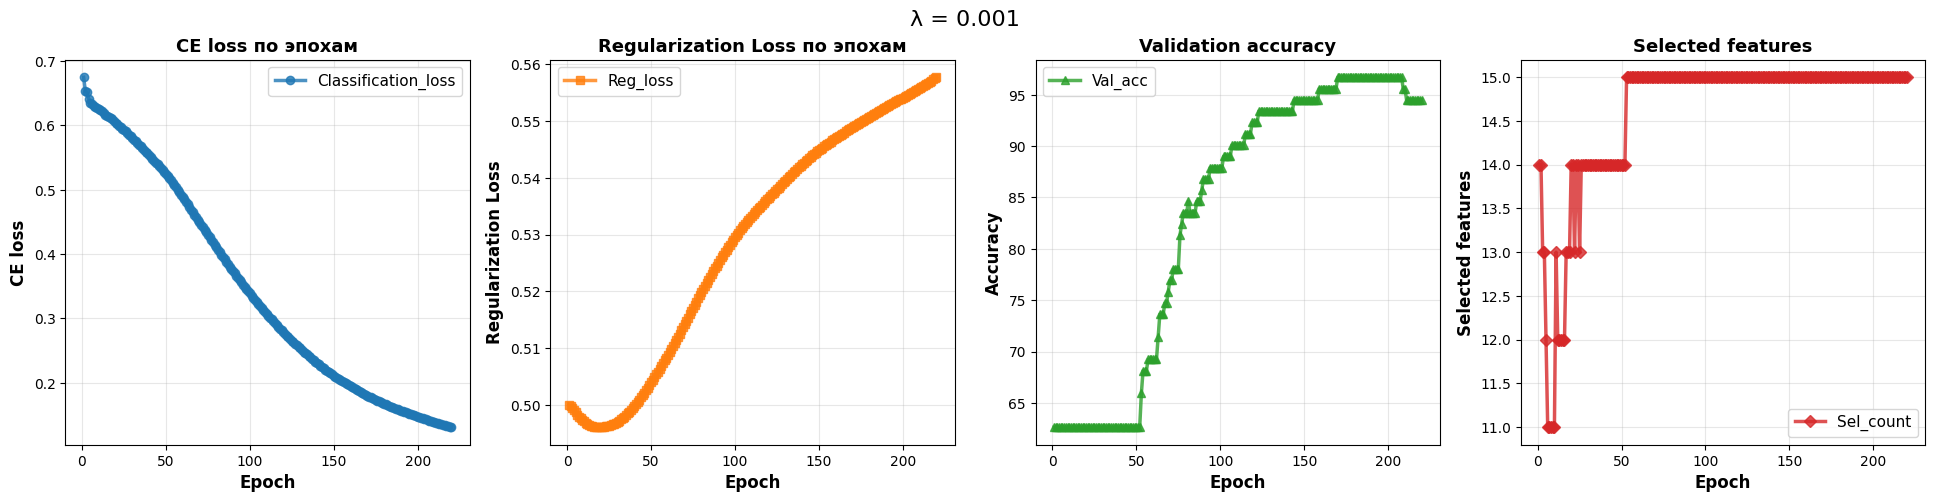

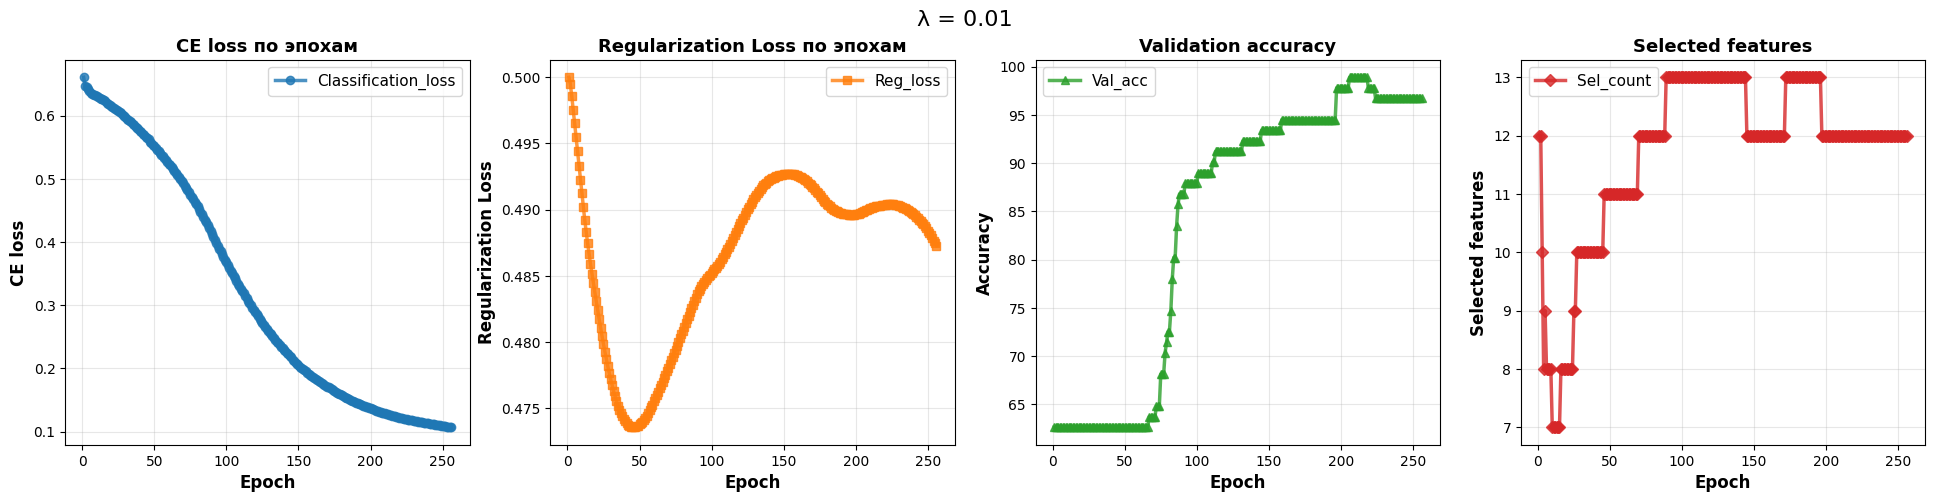

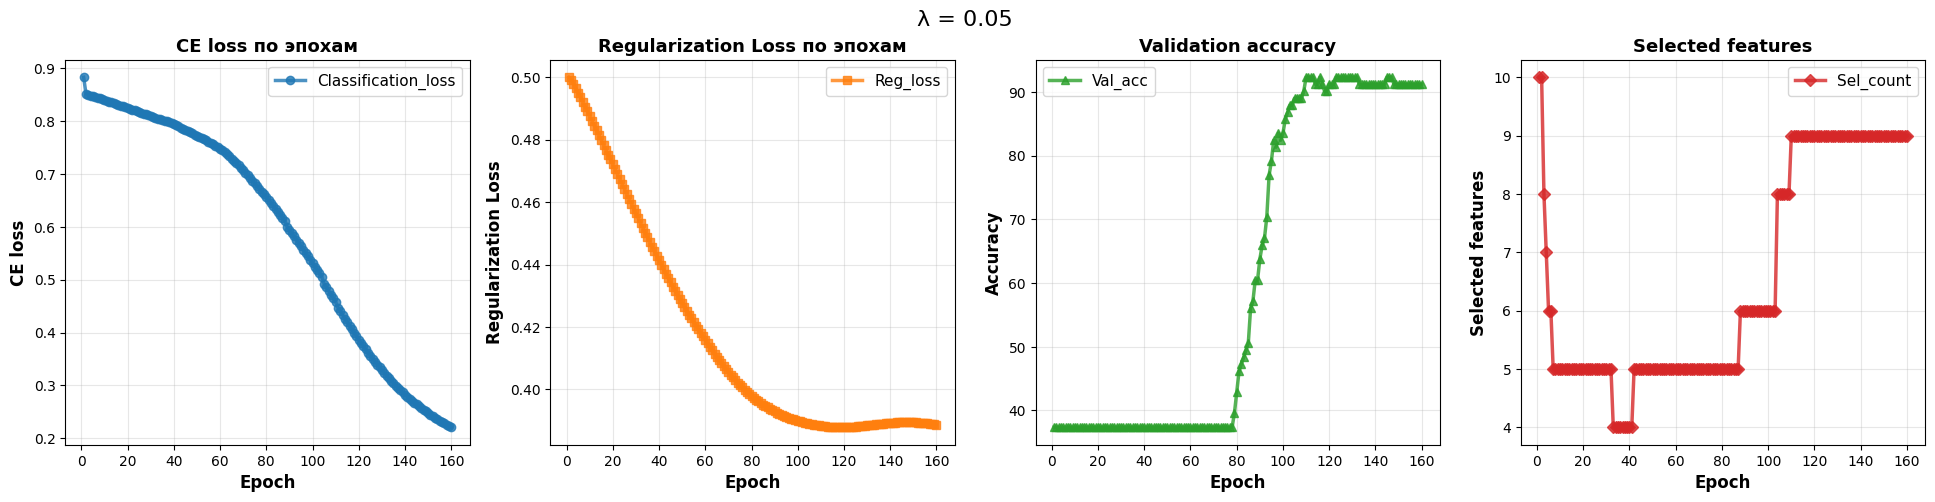

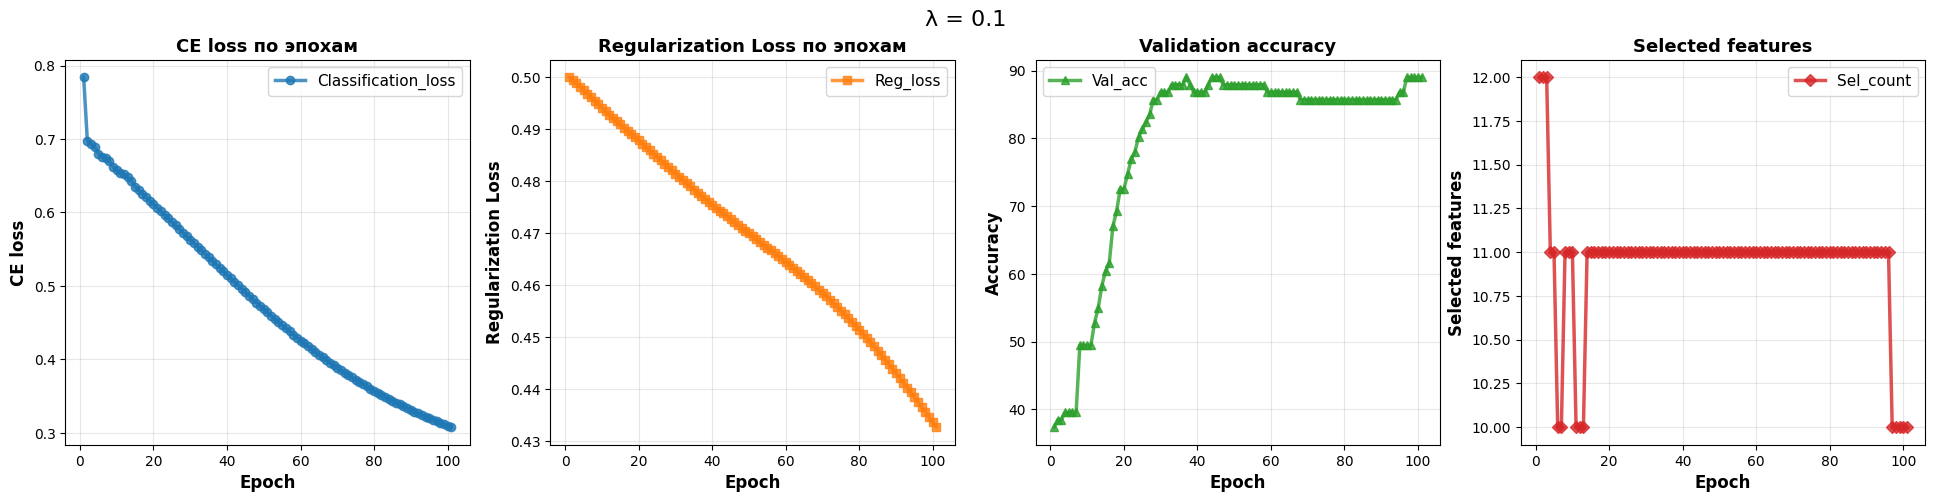

In [68]:
for key in breast_cancer_ste_res.keys():
  plot_comparison_12figures(breast_cancer_ste_res[key], file_name=f'Ste_breast_cancer_lambda_{key}.png', lambda_=key)

#### Feature selection using GumbelLayer

In [59]:
breast_cancer_gumbel_res = {}
for lambda_reg in lambda_reg_array:
    model_gumbel = ModelFeatureSelection(nn.Sequential(
        nn.Linear(30, 10),
        nn.ReLU(),
        nn.Linear(10, 5),
        nn.ReLU(),
        nn.Linear(5, 2)
    ), [(0, GumbelLayer(30))])


    optimizer = optim.Adam([
        {"params": model_gumbel.layers[i].parameters(), "lr": 1e-2} if i in model_gumbel.sel_layer_indices else {"params": model_gumbel.layers[i].parameters(), "lr": 1e-3, "weight_decay": 1e-4} for i in range(len(list(model_gumbel.layers)))
    ])
    breast_cancer_gumbel_res[lambda_reg] = fit(model_gumbel, criterion, X_train_t, y_train_t, X_val_t, y_val_t, lambda_reg, n_features)

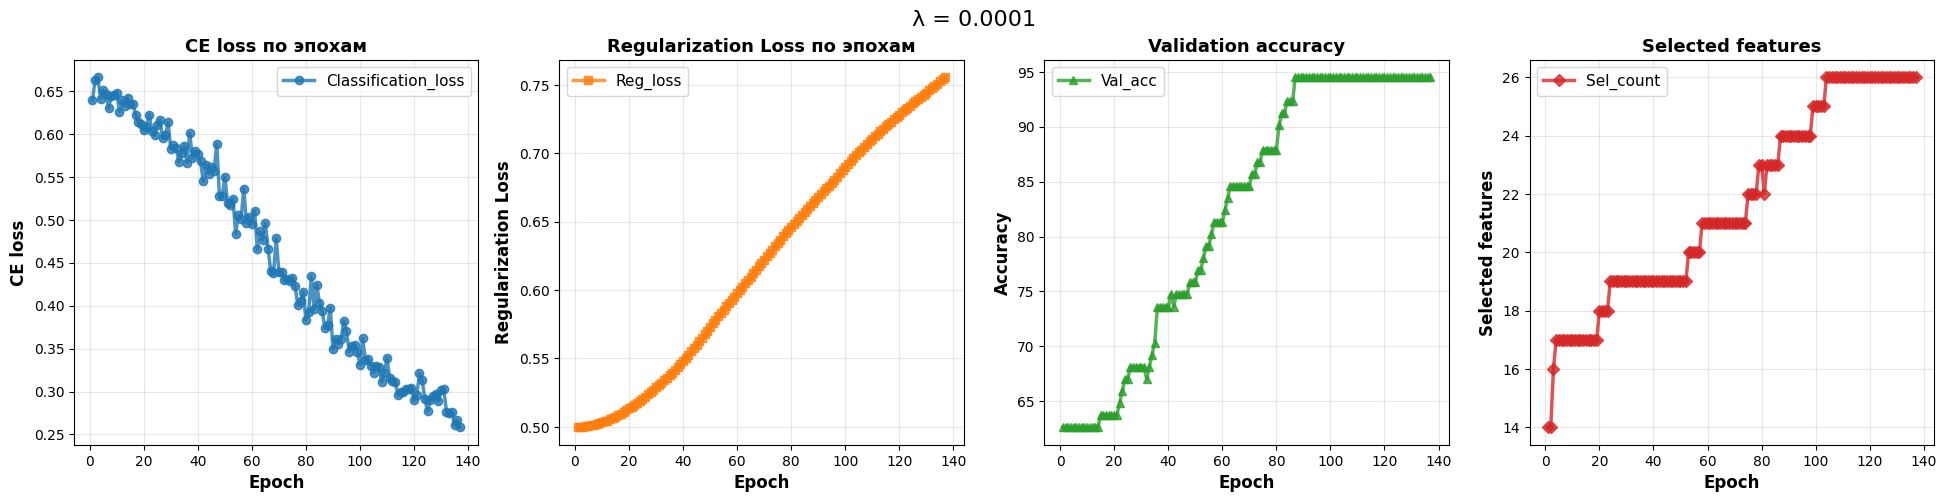

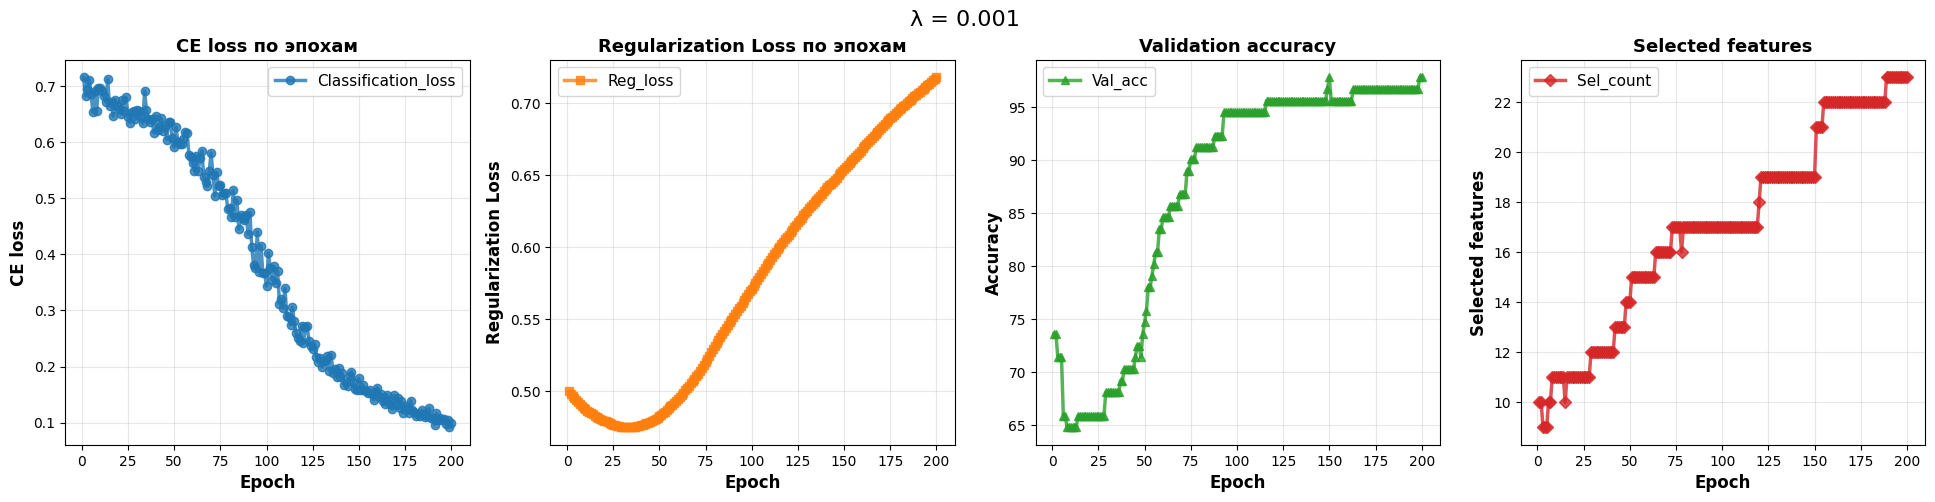

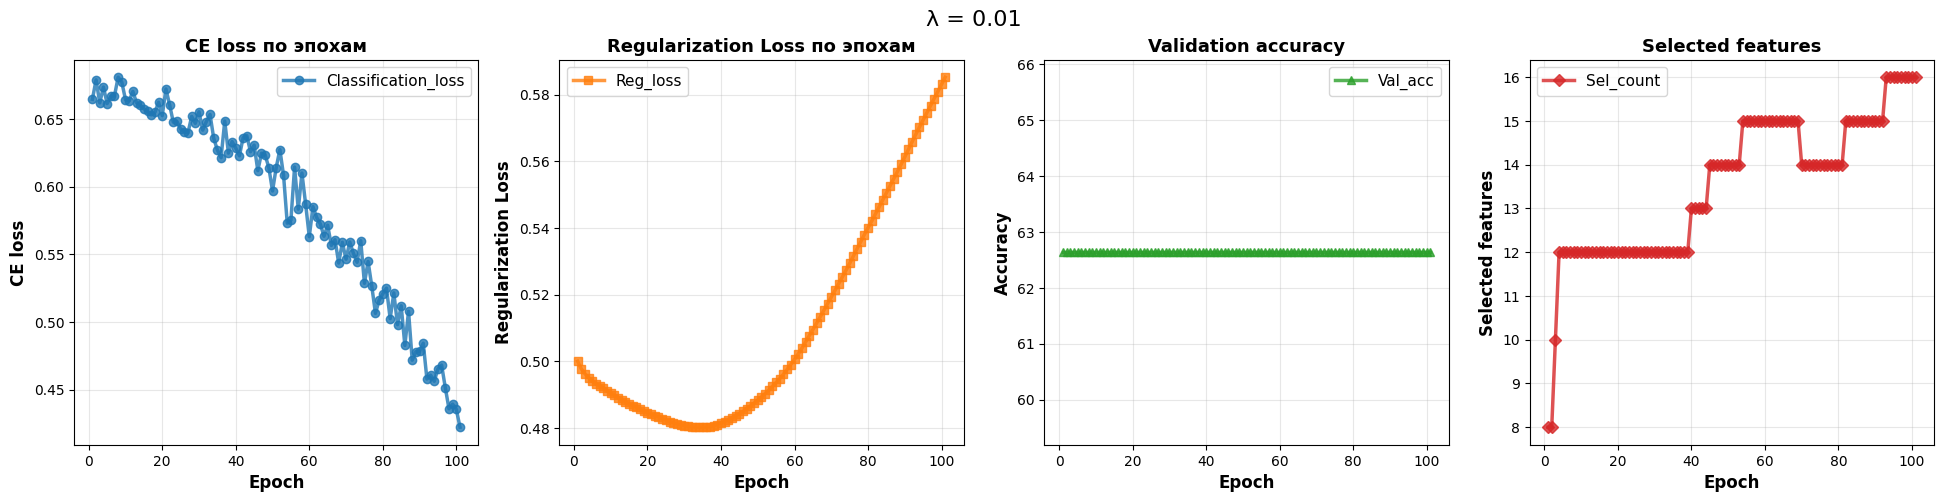

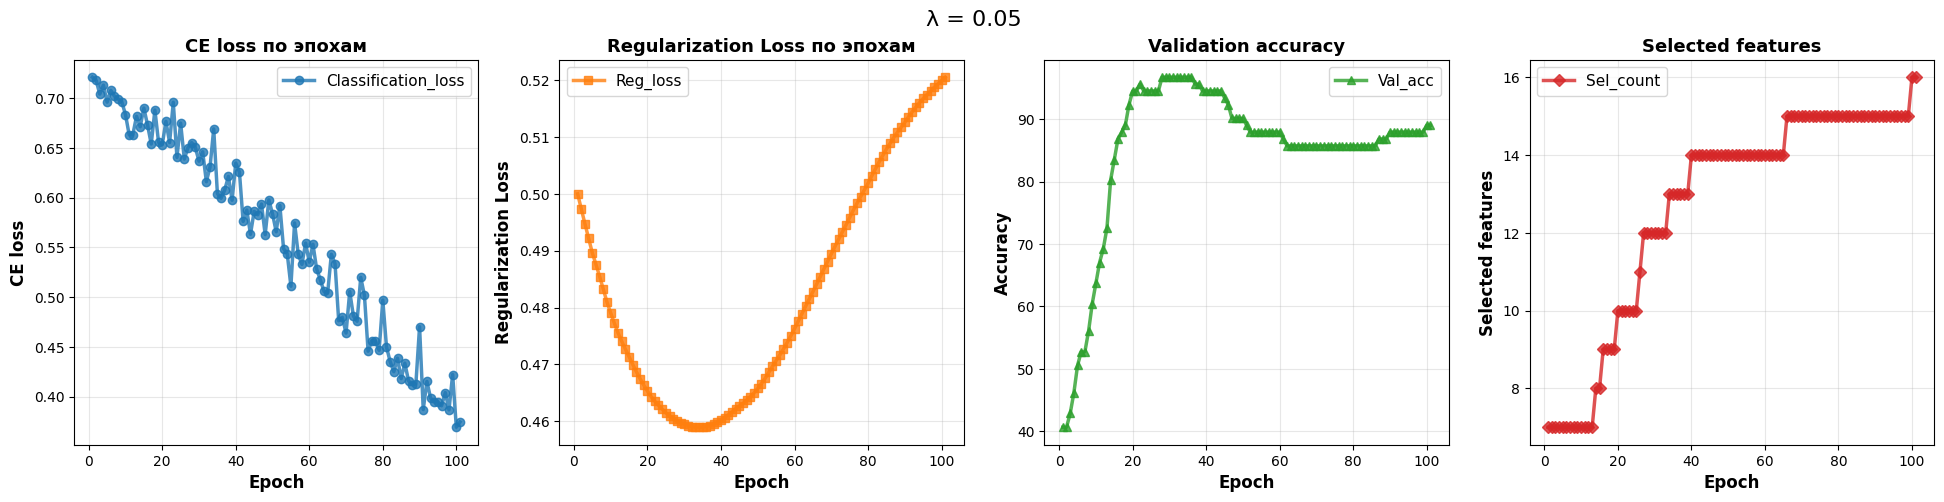

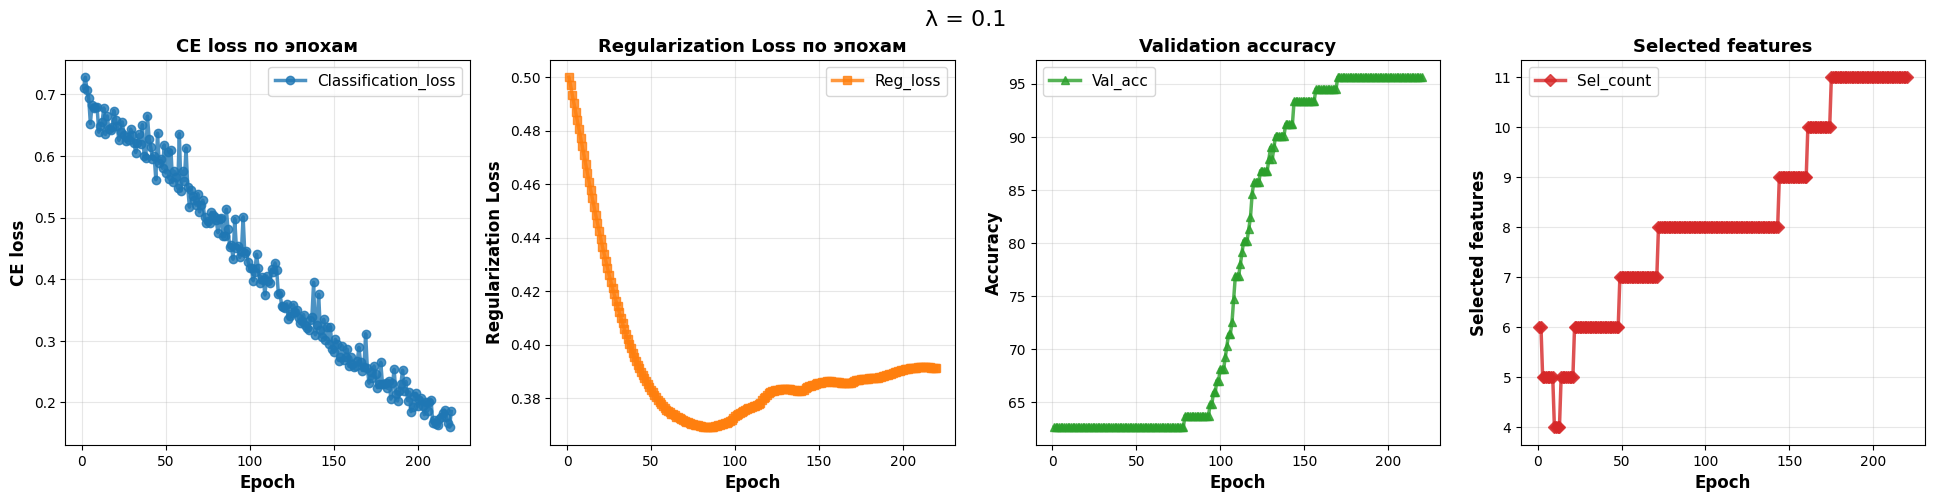

In [69]:
for key in breast_cancer_gumbel_res.keys():
  plot_comparison_12figures(breast_cancer_gumbel_res[key], file_name=f'Gumbel_breast_cancer_lambda_{key}.png', lambda_=key)

#### Feature selection using CorrelatedSTGLayer

In [61]:
breast_cancer_corr_res = {}
for lambda_reg in lambda_reg_array:
    model_corr = ModelFeatureSelection(nn.Sequential(
        nn.Linear(30, 10),
        nn.ReLU(),
        nn.Linear(10, 5),
        nn.ReLU(),
        nn.Linear(5, 2)
    ), [(0, CorrelatedSTGLayer(30))])


    optimizer = optim.Adam([
        {"params": model_corr.layers[i].parameters(), "lr": 1e-2} if i in model_corr.sel_layer_indices else {"params": model_corr.layers[i].parameters(), "lr": 1e-3, "weight_decay": 1e-4} for i in range(len(list(model_corr.layers)))
    ])
    breast_cancer_corr_res[lambda_reg] = fit(model_corr, criterion, X_train_t, y_train_t, X_val_t, y_val_t, lambda_reg, n_features)

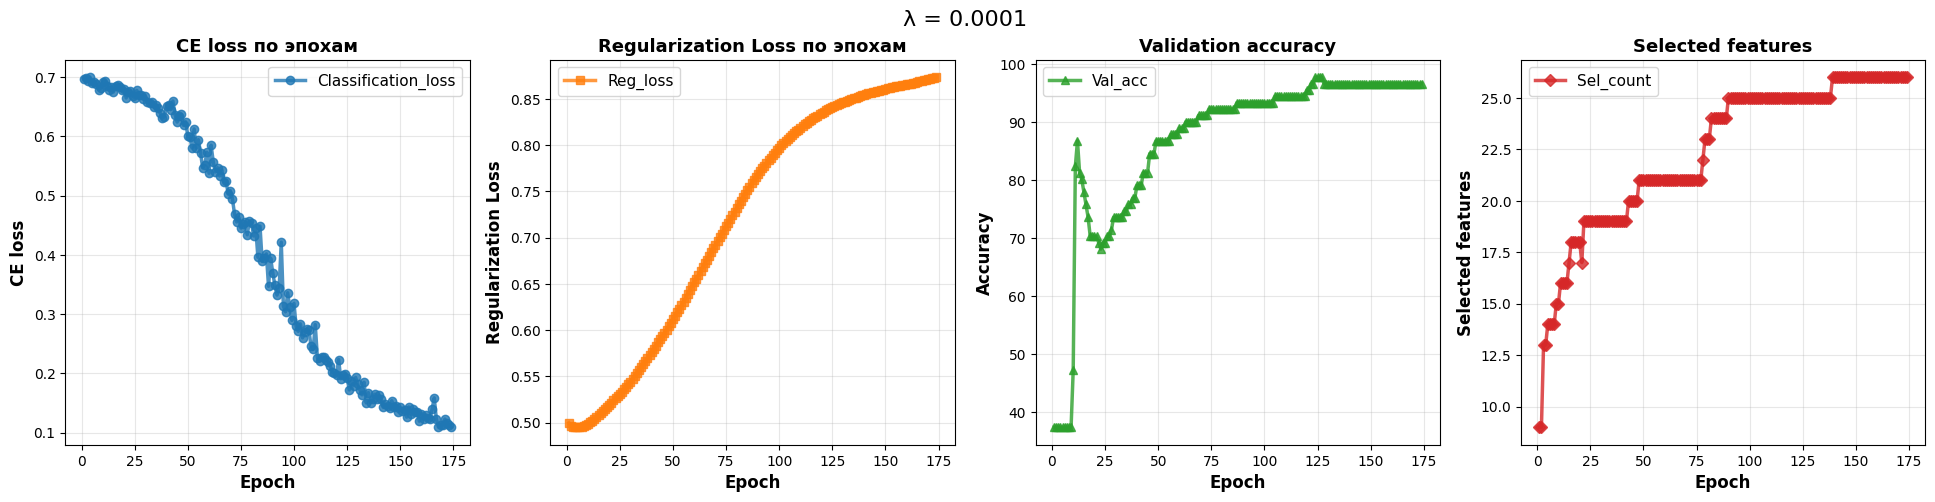

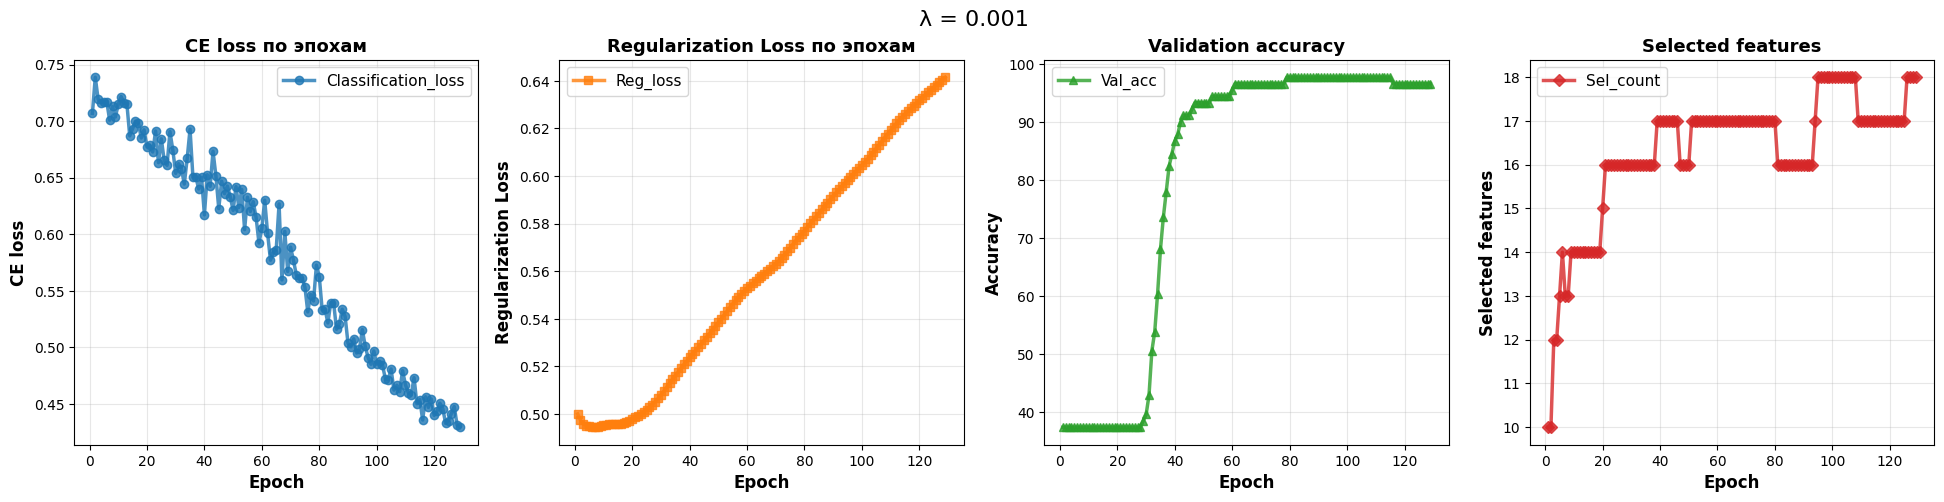

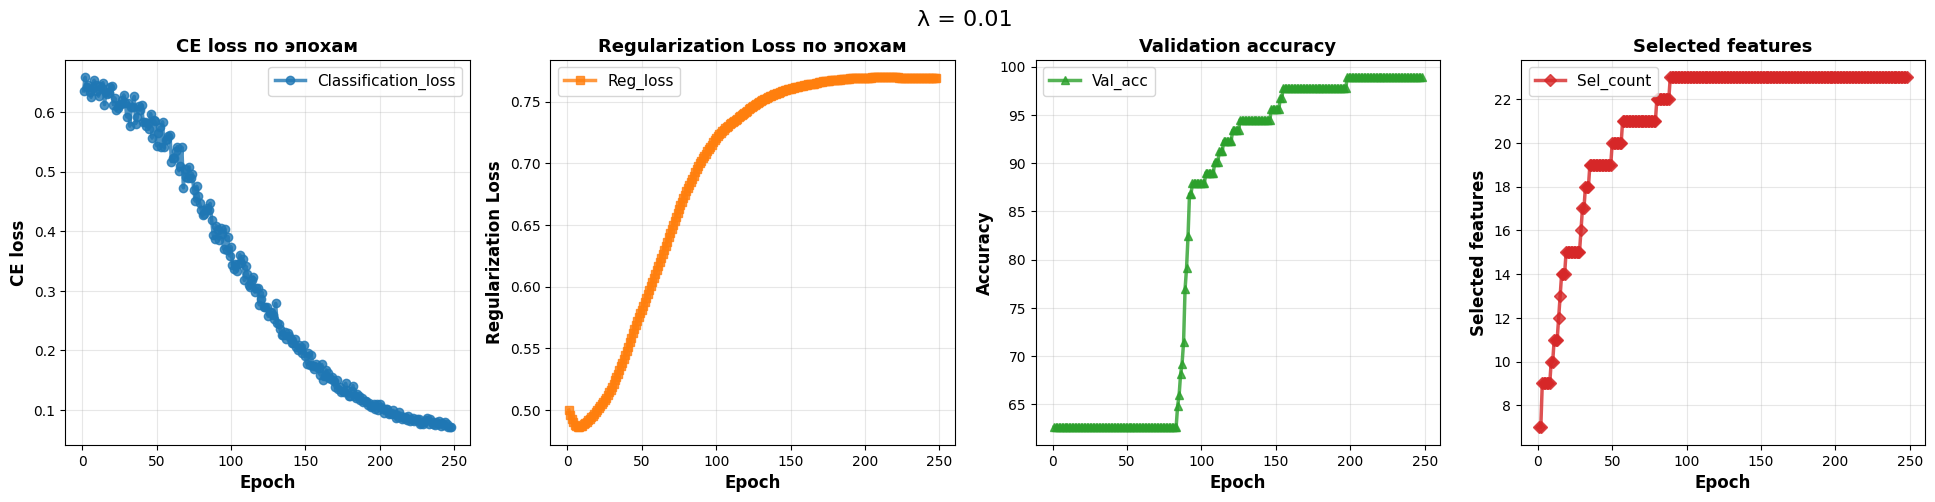

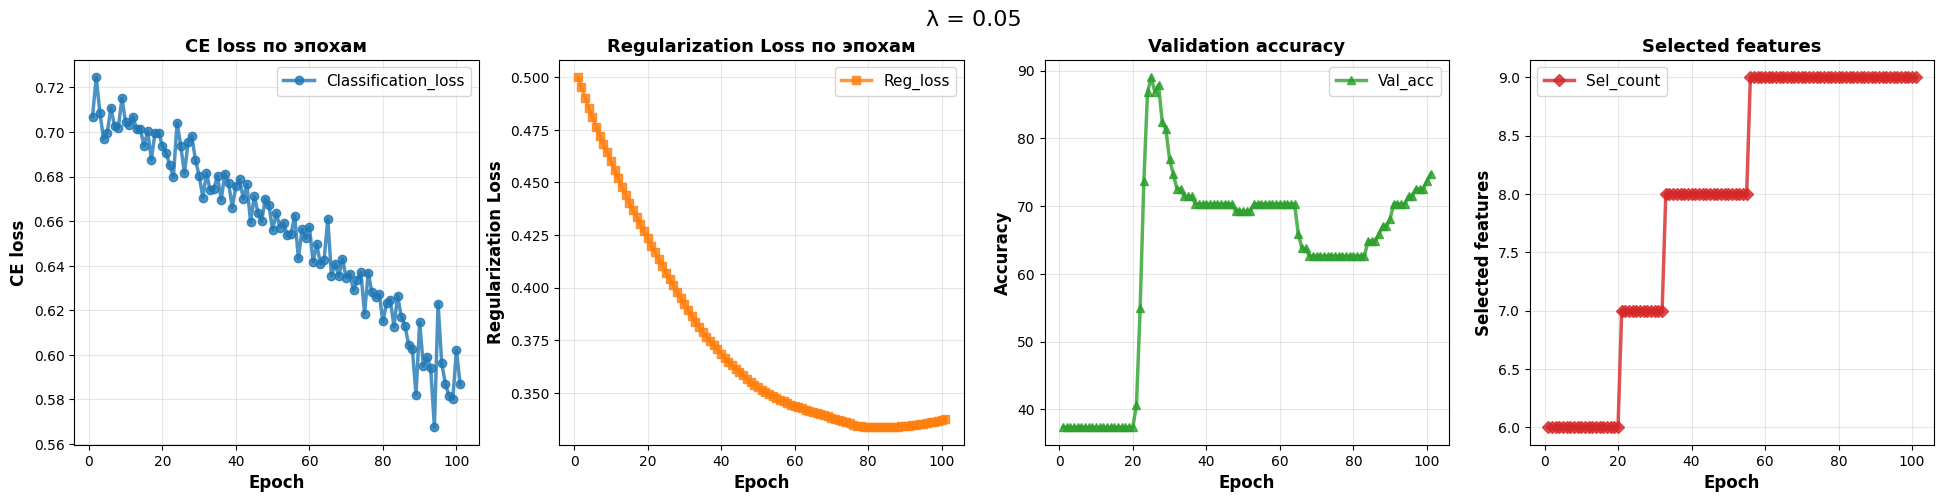

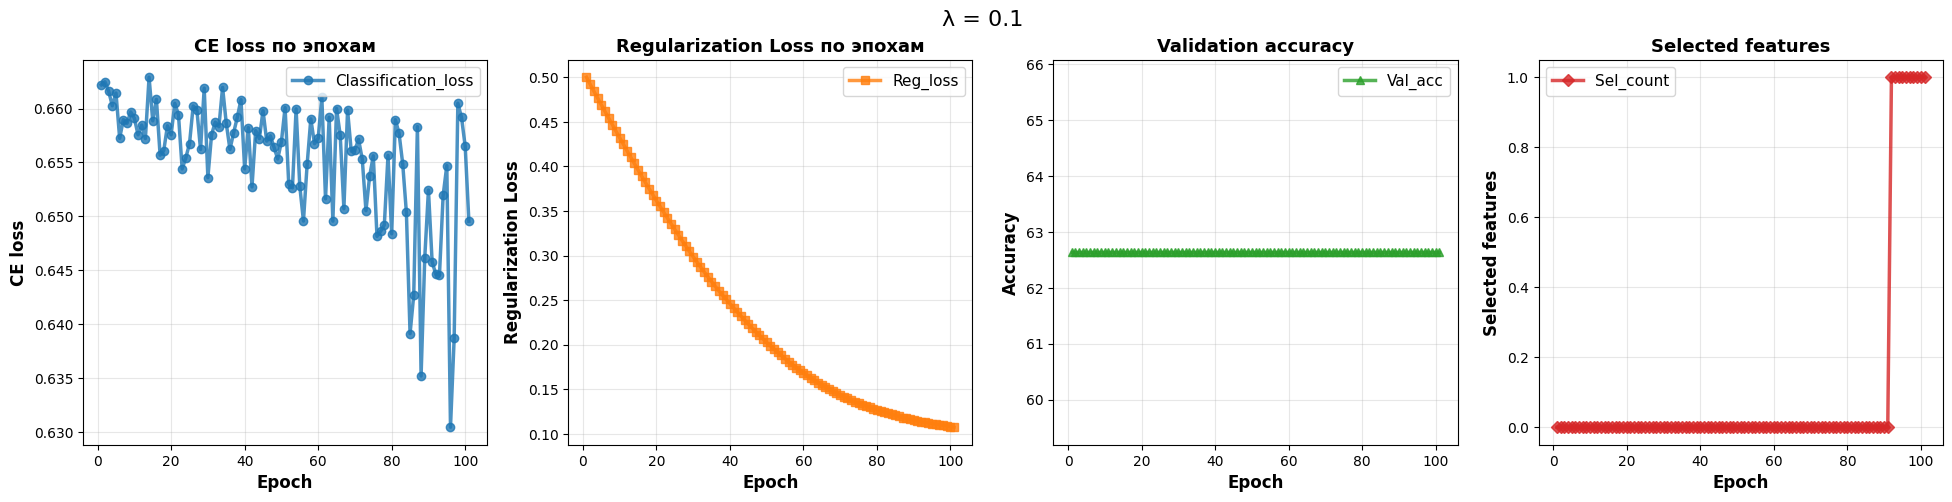

In [70]:
for key in breast_cancer_corr_res.keys():
  plot_comparison_12figures(breast_cancer_corr_res[key], file_name=f'Corr_breast_cancer_lambda_{key}.png', lambda_=key)